In [1]:
###################################
# Goal of this code is to generate KW composite vertical structure of each temperautre tendency term
# so that we can check if the near surface heating anomaly comes from shallow convection scheme (STEND_CLUBB)
# 2024.4.20
# Mu-Ting Chien
#######################################

In [2]:
import os
import sys
sys.path.append('/glade/work/muting/function/')
import KW_diagnostics as KW
import mjo_mean_state_diagnostics as MJO
import create_my_colormap as mycolor
RWB = mycolor.red_white_blue()
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap # for plotting KW composite vertical structure

/glade/u/ssg/ch/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
dir_out            = '/glade/work/muting/KW/'
CASENAME_LIST2     = list(['SST_AQP3_Qobs_27_-4K',\
                          'SST_AQP3_Qobs_27',\
                          'SST_AQP3_Qobs_27_4K'])
CASENAME_SHORT_LIST = list(['-4K','CTL','4K'])

icase          = 0 # 0-2 (-4K, CTL, or +4K)
icase_ref      = icase
if icase != 1:
    CASENAME       = CASENAME_LIST2[icase]+'_3h_20y_CLUBB_new'
else:
    CASENAME       = CASENAME_LIST2[icase]+'_3h_20y_CLUBB_new_uv_tendency'
figdir         = dir_out+'figure/Post_general/Test_CLUBB/'+CASENAME_SHORT_LIST[icase]+'/'
CASENAME_SHORT = CASENAME_SHORT_LIST[icase]+'_CLUBB_new'
#CASE_SHORT     = CASENAME_SHORT_LIST[icase]+'_10y' # only used for signal strength, not needed for now
CASENAME_org = CASENAME
output_dir_all = dir_out+'output_data/All_3hr_10yr/'

os.makedirs(figdir, exist_ok=True)
output_dir = dir_out+'output_data/'+CASENAME+'/'
os.makedirs(output_dir, exist_ok=True)
s2d = 86400
Cp = 1004.64

iyr_min = 2
iyr_max = 4
nyr = iyr_max-iyr_min+1
yr = np.arange(0,nyr)+1
latmax = 10

# Constant used for KW phase composite
pi  = np.pi
PI = '\u03C0'
bin_simple = np.arange(-pi,pi+1/4*pi,1/4*pi)

In [4]:
# KW band for each simulation
if icase == 0: #-4K
    freq_min = 1/8
    freq_max = 1/2.5
    wnum_min = 1
    wnum_max = 15
    h_min    = 8
    h_max    = 50
elif icase == 1: #CTL
    freq_min = 1/7
    freq_max = 1/2.25
    wnum_min = 1
    wnum_max = 15
    h_min    = 12 
    h_max    = 90 
elif icase == 2: #+4K
    freq_min = 1/4
    freq_max = 1/2
    wnum_min = 1
    wnum_max = 15
    h_min    = 25 
    h_max    = 150

In [72]:
##################################################
# Diagnostic 0: Calculate KW phase by precip
################################################
precip_saved = 1
if precip_saved == 0:
    
    # (0) Get nfile_skip
    nfile_skip = KW.find_nfile_skip(CASENAME, CASENAME_SHORT, iyr_min, iyr_max, from_cheyenne=0)
    print(nfile_skip)

    # (1) Load precip
    precip, time, lat, lon = KW.load_2D_data_as_1variable(CASENAME, 'PRECL','PRECC', iyr_min, iyr_max, latmax, \
                                                          1000*s2d, nfile_skip, KW_proj=0, from_cheyenne=0)
    print('finish loading')

    # (1.5) Calculate non-projected precip anomaly, used for signal strength
    nt    = np.size(precip,0)
    pr_m2 = np.mean(precip,0)
    pr_m2 = np.tile(pr_m2,(nt,1,1))
    pr_ano = precip - pr_m2
    del pr_m2
    
    # Save precip
    np.savez(output_dir+'precip.npz', precip=precip, pr_ano=pr_ano, time=time, lat=lat, lon=lon)

else:
    data = np.load(output_dir+'precip.npz')
    precip = data['precip']
    pr_ano = data['pr_ano']
    time   = data['time']
    lon    = data['lon']
    lat    = data['lat']

In [73]:
precip_kw_saved = 1

if precip_kw_saved == 0:

    # (2) KW meridional projection / remove 10-day low-pass variability
    pr_kwproj = KW.KW_meridional_projection(precip, lat, tropics_or_midlat=0)
    pr_kwproj_ano = MJO.remove_10d_from_3hr_data(pr_kwproj)

    print('finish KW proj')

    # (4) KW-filtered precip
    KW_filtered_pr, time_pr = KW.KW_wavenumber_frequency_filter(pr_kwproj_ano, wnum_min, wnum_max,\
                    freq_min, freq_max, h_min, h_max)
    print('finish KW filtering')

    # Make sure time dimension is the same as phase_kw
    pr_kwproj_ano_short = pr_kwproj_ano[time_pr[0]:time_pr[-1]+1,:]

    # Calculate KW composite
    pr_KW_20y, phase_bin, phase_correct = KW.calculate_KW_phase(KW_filtered_pr, 'pr', 'mm/day', figdir)
    
    # Save kw precip
    np.savez(output_dir+'precip_kw.npz', pr_kwproj_ano_short=pr_kwproj_ano_short, KW_filtered_pr=KW_filtered_pr, \
         time_pr=time_pr, lon=lon, phase_bin=phase_bin, phase_correct=phase_correct, pr_kw = pr_KW_20y)
    
else:
    
    data = np.load(output_dir+'precip_kw.npz')
    pr_kwproj_ano_short = data['pr_kwproj_ano_short']
    KW_filtered_pr      = data['KW_filtered_pr']
    time_pr             = data['time_pr']
    lon                 = data['lon']
    phase_bin           = data['phase_bin']
    phase_correct       = data['phase_correct']

In [7]:
kw_amplitude_saved = 1

if kw_amplitude_saved == 0:
    
    # Composite by KW phase
    pr_KW, bin_center = KW.composite_by_kw_phase(pr_kwproj_ano_short[:,:], phase_correct[:,:], time_pr[:])
    plt.plot(bin_center, pr_KW,'k-o')
    plt.show()
    KW_amplitude = ( np.abs( np.min(pr_KW) )+ np.max(pr_KW) )/2 
    np.savez(output_dir+'kw_amplitude_gr_Cp.npz', KW_amplitude=KW_amplitude)
    
else:

    # Load KW composite field
    data = np.load(output_dir+'kw_amplitude_gr_Cp.npz')  
    KW_amplitude = data['KW_amplitude']

print('KW amplitude:',KW_amplitude)

KW amplitude: 3.2871589250272217


Lev:  0
Lev:  1
Lev:  2
Lev:  3
Lev:  4
Lev:  5
Lev:  6
Lev:  7
Lev:  8
Lev:  9
Lev:  10
Lev:  11
Lev:  12
Lev:  13
Lev:  14
Lev:  15
Lev:  16
Lev:  17
Lev:  18
Lev:  19
Lev:  20
Lev:  21
Lev:  22
Lev:  23
Lev:  24
Lev:  25
Lev:  26
Lev:  27
Lev:  28
Lev:  29
Lev:  30
Lev:  31
Lev:  32
Lev:  33
Lev:  34
Lev:  35
Lev:  36
Lev:  37
Lev:  38
Lev:  39
Finish term 1
Lev:  0
Lev:  1
Lev:  2
Lev:  3
Lev:  4
Lev:  5
Lev:  6
Lev:  7
Lev:  8
Lev:  9
Lev:  10
Lev:  11
Lev:  12
Lev:  13
Lev:  14
Lev:  15
Lev:  16
Lev:  17
Lev:  18
Lev:  19
Lev:  20
Lev:  21
Lev:  22
Lev:  23
Lev:  24
Lev:  25
Lev:  26
Lev:  27
Lev:  28
Lev:  29
Lev:  30
Lev:  31
Lev:  32
Lev:  33
Lev:  34
Lev:  35
Lev:  36
Lev:  37
Lev:  38
Lev:  39
Finish term 2
Lev:  0
Lev:  1
Lev:  2
Lev:  3
Lev:  4
Lev:  5
Lev:  6
Lev:  7
Lev:  8
Lev:  9
Lev:  10
Lev:  11
Lev:  12
Lev:  13
Lev:  14
Lev:  15
Lev:  16
Lev:  17
Lev:  18
Lev:  19
Lev:  20
Lev:  21
Lev:  22
Lev:  23
Lev:  24
Lev:  25
Lev:  26
Lev:  27
Lev:  28
Lev:  29
Lev:  30
Lev

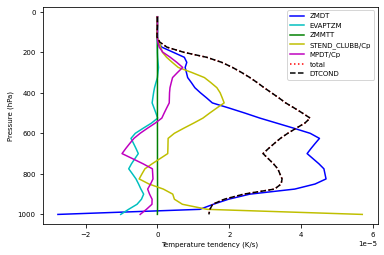

In [47]:
##################################################
# Diagnostic 1: Calcualte KW composite temperature tendency decomposition
################################################
# Load each tendency term
DTDt_saved = 1

if DTDt_saved == 0:
    
    # (0) Get nfile_skip
    nfile_skip = KW.find_nfile_skip(CASENAME, CASENAME_SHORT, iyr_min, iyr_max, from_cheyenne=0)

    # (1) Load each temperature tendency term & Calculate anomaly
    # Note that we have verified that ZMDT + EVAPTZM + ZMMTT (very small) + STEND_CLUBB/Cp + MPDT/Cp
    vname = list(['DTCOND'])
    DTCOND_proj, DTCOND_m, time, plev, lon = KW.load_3D_data_as_1variable(CASENAME, CASENAME_SHORT, vname, iyr_min, iyr_max, latmax, nfile_skip, from_cheyenne=0)
    DTCOND_ano = MJO.remove_10d_from_3hr_data(DTCOND_proj) #(time, plev, lon)
    # Save Term 1 data
    np.savez(output_dir+'dTdt_each_term.npz', \
             DTCOND_proj=DTCOND_proj, DTCOND_m=DTCOND_m, DTCOND_ano=DTCOND_ano,\
             time=time, plev=plev, lon=lon)
    print('Finish term 1')

    
    vname = list(['ZMDT'])
    ZMDT_proj, ZMDT_m, time, plev, lon = KW.load_3D_data_as_1variable(CASENAME, CASENAME_SHORT, vname, iyr_min, iyr_max, latmax, nfile_skip, from_cheyenne=0)
    ZMDT_ano = MJO.remove_10d_from_3hr_data(ZMDT_proj) #(time, plev, lon)
    # Save Term 2 data
    np.savez(output_dir+'dTdt_each_term.npz', \
             DTCOND_proj=DTCOND_proj, DTCOND_m=DTCOND_m, DTCOND_ano=DTCOND_ano,\
             ZMDT_proj=ZMDT_proj, ZMDT_m=ZMDT_m, ZMDT_ano=ZMDT_ano,\
             time=time, plev=plev, lon=lon)
    print('Finish term 2')

    vname = list(['EVAPTZM'])
    EVAPTZM_proj, EVAPTZM_m, time, plev, lon = KW.load_3D_data_as_1variable(CASENAME, CASENAME_SHORT, vname, iyr_min, iyr_max, latmax, nfile_skip, from_cheyenne=0)
    EVAPTZM_ano = MJO.remove_10d_from_3hr_data(EVAPTZM_proj) #(time, plev, lon)
    # Save Term 3 data
    np.savez(output_dir+'dTdt_each_term.npz', \
             DTCOND_proj=DTCOND_proj, DTCOND_m=DTCOND_m, DTCOND_ano=DTCOND_ano,\
             ZMDT_proj=ZMDT_proj, ZMDT_m=ZMDT_m, ZMDT_ano=ZMDT_ano,\
             EVAPTZM_proj=EVAPTZM_proj, EVAPTZM_m=EVAPTZM_m, EVAPTZM_ano=EVAPTZM_ano,\
             time=time, plev=plev, lon=lon)
    print('Finish term 3')

    vname = list(['ZMMTT'])
    ZMMTT_proj, ZMMTT_m, time, plev, lon = KW.load_3D_data_as_1variable(CASENAME, CASENAME_SHORT, vname, iyr_min, iyr_max, latmax, nfile_skip, from_cheyenne=0)
    ZMMTT_ano = MJO.remove_10d_from_3hr_data(ZMMTT_proj) #(time, plev, lon)
    # Save Term 4 data
    np.savez(output_dir+'dTdt_each_term.npz', \
             DTCOND_proj=DTCOND_proj, DTCOND_m=DTCOND_m, DTCOND_ano=DTCOND_ano,\
             ZMDT_proj=ZMDT_proj, ZMDT_m=ZMDT_m, ZMDT_ano=ZMDT_ano,\
             EVAPTZM_proj=EVAPTZM_proj, EVAPTZM_m=EVAPTZM_m, EVAPTZM_ano=EVAPTZM_ano,\
             ZMMTT_proj=ZMMTT_proj, ZMMTT_m=ZMMTT_m, ZMMTT_ano=ZMMTT_ano,\
             time=time, plev=plev, lon=lon)
    print('Finish term 4')
    
    vname = list(['STEND_CLUBB']) # this is normalized by Cp so that it is the same unit as other terms (K/s)
    STEND_CLUBB_proj, STEND_CLUBB_m, time, plev, lon = KW.load_3D_data_as_1variable(CASENAME, CASENAME_SHORT, vname, iyr_min, iyr_max, latmax, nfile_skip, from_cheyenne=0)
    STEND_CLUBB_ano = MJO.remove_10d_from_3hr_data(STEND_CLUBB_proj) #(time, plev, lon)
    STEND_CLUBB_proj = STEND_CLUBB_proj/Cp
    STEND_CLUBB_m    = STEND_CLUBB_m/Cp
    STEND_CLUBB_ano  = STEND_CLUBB_ano/Cp
    # Save Term 5 data
    np.savez(output_dir+'dTdt_each_term.npz', \
             DTCOND_proj=DTCOND_proj, DTCOND_m=DTCOND_m, DTCOND_ano=DTCOND_ano,\
             ZMDT_proj=ZMDT_proj, ZMDT_m=ZMDT_m, ZMDT_ano=ZMDT_ano,\
             EVAPTZM_proj=EVAPTZM_proj, EVAPTZM_m=EVAPTZM_m, EVAPTZM_ano=EVAPTZM_ano,\
             ZMMTT_proj=ZMMTT_proj, ZMMTT_m=ZMMTT_m, ZMMTT_ano=ZMMTT_ano,\
             STEND_CLUBB_proj=STEND_CLUBB_proj, STEND_CLUBB_m=STEND_CLUBB_m, STEND_CLUBB_ano=STEND_CLUBB_ano,\
             time=time, plev=plev, lon=lon)   
    print('Finish term 5')
    
    vname = list(['MPDT']) # this is normalized by Cp so that it is the same unit as other terms (K/s)
    MPDT_proj, MPDT_m, time, plev, lon = KW.load_3D_data_as_1variable(CASENAME, CASENAME_SHORT, vname, iyr_min, iyr_max, latmax, nfile_skip, from_cheyenne=0)
    MPDT_ano = MJO.remove_10d_from_3hr_data(MPDT_proj) #(time, plev, lon)
    MPDT_proj = MPDT_proj/Cp
    MPDT_m    = MPDT_m/Cp
    MPDT_ano  = MPDT_ano/Cp
    # Save Term 6 data
    np.savez(output_dir+'dTdt_each_term.npz', \
             DTCOND_proj=DTCOND_proj, DTCOND_m=DTCOND_m, DTCOND_ano=DTCOND_ano,\
             ZMDT_proj=ZMDT_proj, ZMDT_m=ZMDT_m, ZMDT_ano=ZMDT_ano,\
             EVAPTZM_proj=EVAPTZM_proj, EVAPTZM_m=EVAPTZM_m, EVAPTZM_ano=EVAPTZM_ano,\
             ZMMTT_proj=ZMMTT_proj, ZMMTT_m=ZMMTT_m, ZMMTT_ano=ZMMTT_ano,\
             STEND_CLUBB_proj=STEND_CLUBB_proj, STEND_CLUBB_m=STEND_CLUBB_m, STEND_CLUBB_ano=STEND_CLUBB_ano,\
             MPDT_proj=MPDT_proj, MPDT_m=MPDT_m, MPDT_ano=MPDT_ano,\
             time=time, plev=plev, lon=lon) 
    print('Finish term 6')
    
    DTDT_tot_m = ZMDT_m + EVAPTZM_m + ZMMTT_m + STEND_CLUBB_m + MPDT_m
    # Test: check mean state makes sense
    plt.plot(ZMDT_m, plev, 'b')
    plt.plot(EVAPTZM_m, plev, 'c')
    plt.plot(ZMMTT_m, plev, 'g')
    plt.plot(STEND_CLUBB_m, plev, 'y')
    plt.plot(MPDT_m, plev, 'm')
    plt.plot(DTDT_tot_m, plev, 'r:')
    plt.plot(DTCOND_m, plev, 'k--')
    plt.gca().invert_yaxis()
    plt.legend(['ZMDT','EVAPTZM','ZMMTT','STEND_CLUBB/Cp','MPDT/Cp','total','DTCOND'])
    plt.xlabel('Temperature tendency (K/s)')
    plt.ylabel('Pressure (hPa)')
    plt.show()
    
else:
    data = np.load(output_dir+'dTdt_each_term.npz')
    #DTCOND_proj = data['DTCOND_proj'] #(time, plev, lon), raw DTCOND data projected onto KW meridional structure
    DTCOND_ano = data['DTCOND_ano'] #(time, plev, lon), projected DTCOND, without 10-day low pass filtered variability
    ZMDT_ano   = data['ZMDT_ano'] 
    EVAPTZM_ano = data['EVAPTZM_ano']
    ZMMTT_ano = data['ZMMTT_ano']
    STEND_CLUBB_ano = data['STEND_CLUBB_ano']
    MPDT_ano   = data['MPDT_ano']
    time  = data['time']
    plev  = data['plev']
    lon   = data['lon']


In [5]:
# Composite by KW phase
T_tendency_kw_saved = 1

if T_tendency_kw_saved == 0:

    # Make sure each tendency term have the same size as kw-filtered precip
    DTCOND_trim      = DTCOND_ano[time_pr[0]:time_pr[-1]+1, :, :]
    ZMDT_trim        = ZMDT_ano[time_pr[0]:time_pr[-1]+1, :, :]
    EVAPTZM_trim     = EVAPTZM_ano[time_pr[0]:time_pr[-1]+1, :, :]
    ZMMTT_trim       = ZMMTT_ano[time_pr[0]:time_pr[-1]+1, :, :]
    STEND_CLUBB_trim = STEND_CLUBB_ano[time_pr[0]:time_pr[-1]+1, :, :]
    MPDT_trim        = MPDT_ano[time_pr[0]:time_pr[-1]+1, :, :]
    
    DTCOND_KW,      phase = KW.composite_by_kw_phase(DTCOND_trim[:,:,:],      phase_correct[:,:], time_pr[:]) #(phase, plev)
    ZMDT_KW,        phase = KW.composite_by_kw_phase(ZMDT_trim[:,:,:],        phase_correct[:,:], time_pr[:])
    EVAPTZM_KW,     phase = KW.composite_by_kw_phase(EVAPTZM_trim[:,:,:],     phase_correct[:,:], time_pr[:])
    ZMMTT_KW,       phase = KW.composite_by_kw_phase(ZMMTT_trim[:,:,:],       phase_correct[:,:], time_pr[:])
    STEND_CLUBB_KW, phase = KW.composite_by_kw_phase(STEND_CLUBB_trim[:,:,:], phase_correct[:,:], time_pr[:])
    MPDT_KW,        phase = KW.composite_by_kw_phase(MPDT_trim[:,:,:],        phase_correct[:,:], time_pr[:])
    
    np.savez(output_dir+'dTdt_each_term_kwcomposite.npz', DTCOND_KW=DTCOND_KW, ZMDT_KW=ZMDT_KW, \
             EVAPTZM_KW=EVAPTZM_KW, ZMMTT_KW=ZMMTT_KW, STEND_CLUBB_KW=STEND_CLUBB_KW, MPDT_KW=MPDT_KW,\
             plev=plev, phase=phase)
    
else:
    
    data           = np.load(output_dir+'dTdt_each_term_kwcomposite.npz')
    DTCOND_KW      = data['DTCOND_KW'][:,:]*s2d
    ZMDT_KW        = data['ZMDT_KW'][:,:]*s2d
    EVAPTZM_KW     = data['EVAPTZM_KW'][:,:]*s2d
    ZMMTT_KW       = data['ZMMTT_KW'][:,:]*s2d
    STEND_CLUBB_KW = data['STEND_CLUBB_KW'][:,:]*s2d
    MPDT_KW        = data['MPDT_KW'][:,:]*s2d
    
    plev  = data['plev']
    phase = data['phase']
    nphase = np.size(phase)

3.2871589250272217


/glade/u/ssg/ch/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: No contour levels were found within the data range.
/glade/u/ssg/ch/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: No contour levels were found within the data range.


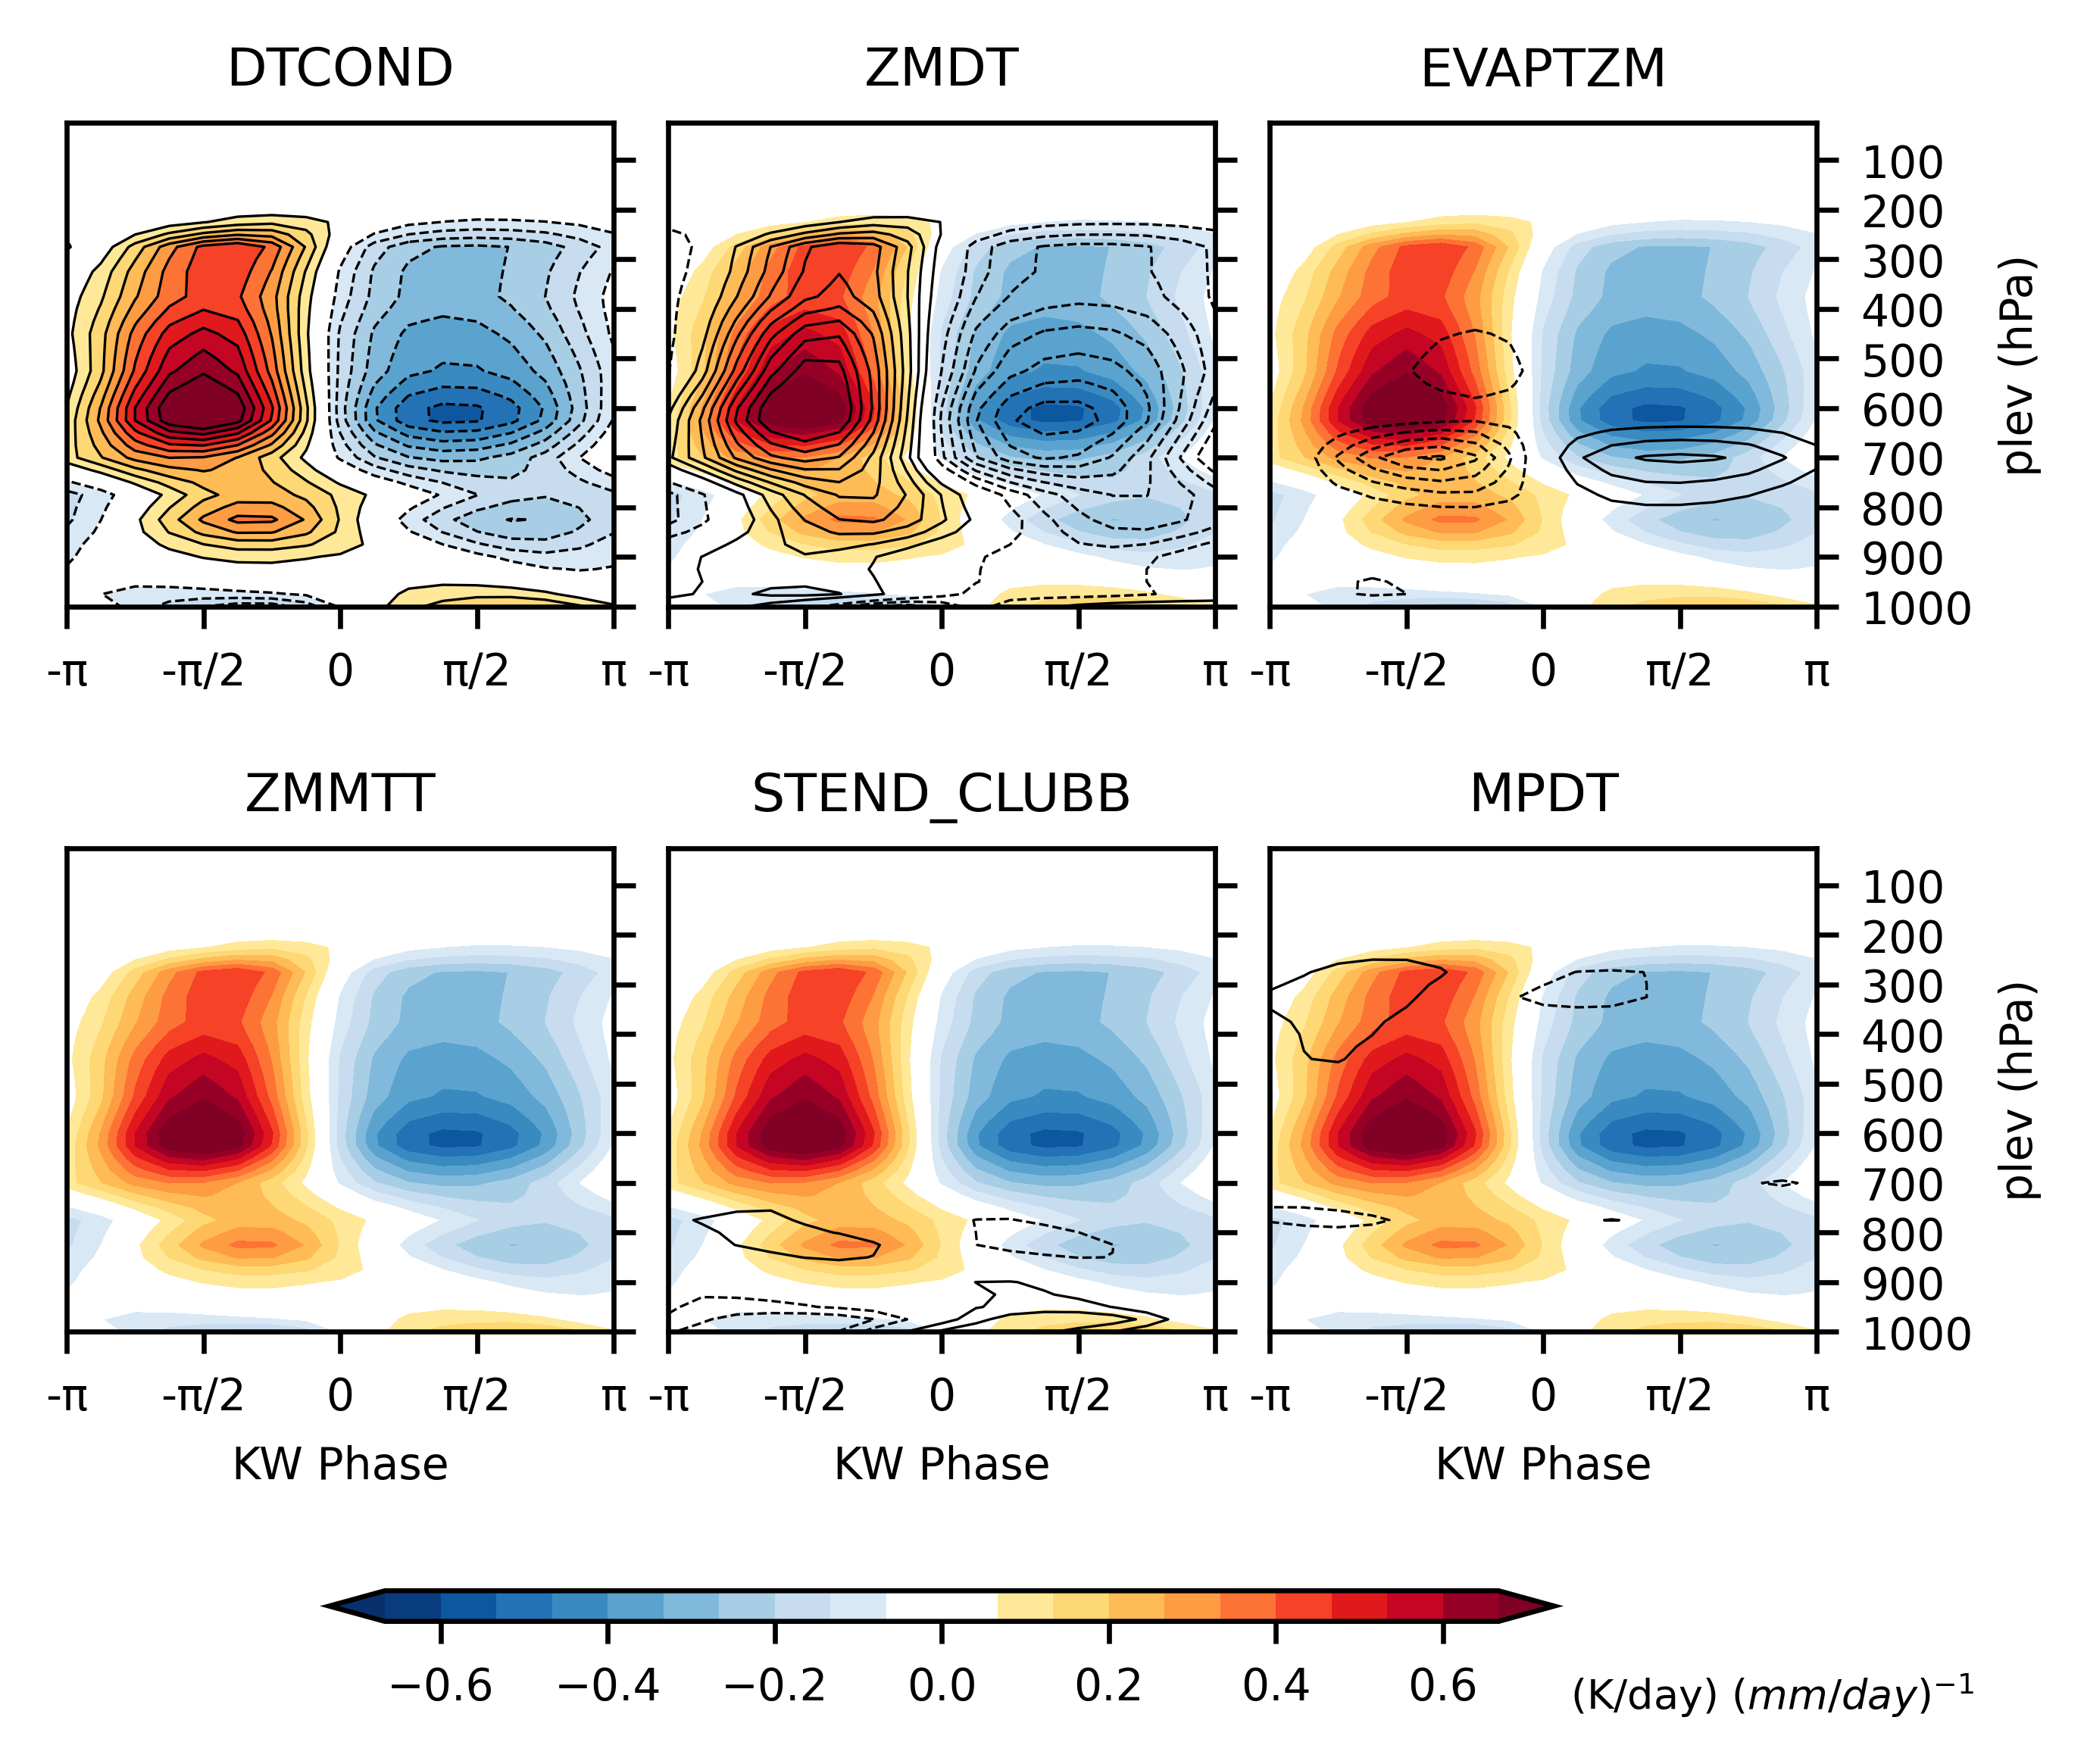

In [13]:
# Plot KW composite vertical structure of each temperature tendency term (repetitive in Paper4_supplementary.ipynb)
normalize_by_kwamp = 1
print(KW_amplitude)

vname_temp_tendency = list(['DTCOND','ZMDT','EVAPTZM','ZMMTT','STEND_CLUBB','MPDT'])
font = 7

fig,axes = plt.subplots(2,3,figsize=(5.5, 4),dpi=600)
plt.subplots_adjust(left=0.2,right=0.9,top=0.95,bottom=0,hspace=0.5,wspace=0.1)
plt.rcParams.update({'font.size': font})

clev_n = np.arange(-2,0,0.2)/3
clev_p = np.arange(0.2,2.2,0.2)/3
clev   = np.arange(-2,2.2,0.2)/3
xx, yy = np.meshgrid(phase, plev)

for iplt in range(0,6):
    plt.subplot(2,3,iplt+1)
    ax = plt.gca()
    VAR_cn = globals() [vname_temp_tendency[iplt]+'_KW']
    VAR_cf = globals() [vname_temp_tendency[0]+'_KW'] # Q total
    if normalize_by_kwamp == 1:
        VAR_cn = VAR_cn/KW_amplitude
        VAR_cf = VAR_cf/KW_amplitude
    if T_tendency_kw_saved == 0:
        VAR_cn = VAR_cn*s2d
        VAR_cf = VAR_cf*s2d
    cf   = plt.contourf(xx, yy, VAR_cf.T, levels=clev, cmap=get_cmap(RWB), extend='both' )
    cn_p = plt.contour(xx, yy, VAR_cn.T, levels=clev_p, colors='k', linewidths=0.4)
    #cn_0 = plt.contour(xx, yy, VAR_cn.T, levels=clev_0, colors='g', linewidths=1.2)
    cn_n = plt.contour(xx, yy, VAR_cn.T, levels=clev_n, colors='k', linestyles='dashed',linewidths=0.4)
    plt.ylim([np.min(plev), np.max(plev)])
    plt.title(vname_temp_tendency[iplt])
    plt.yticks(np.arange(100,1100,100))
    plt.gca().invert_yaxis()
    plt.xticks(np.arange(-pi,pi+pi/2,pi/2),('-'+PI,'-'+PI+'/2','0',PI+'/2',PI),fontsize=font)
    ax.yaxis.set_label_position("right")
    plt.tick_params(bottom=True,top=False,left=False,right=True)
    if iplt == 2 or iplt == 5:
        plt.tick_params(labelbottom=True,labeltop=False,labelleft=False,labelright=True)
        ax.set_ylabel('plev (hPa)',fontsize=font)
    else:
        plt.tick_params(labelbottom=True,labeltop=False,labelleft=False,labelright=False)       

    if iplt > 2:
        plt.xlabel('KW Phase',fontsize=font)

cb = plt.colorbar(cf,ax=axes,orientation = 'horizontal', shrink=.7, aspect=40,pad=0.15) 
ax.text(0.55, -0.8, '(K/day) $(mm/day)^{-1}$',\
                verticalalignment='bottom', horizontalalignment='left',transform=ax.transAxes,\
                color='k', fontsize=6.5)
plt.savefig(figdir+'dTdt_KW.png',dpi=600)
plt.show()
plt.close()

In [56]:
##################################################
# Diagnostic 3: KW composite moisture budget (dqdt, udqdx, vdqdy, wdqdp, Q2)
# This is different from Diaganostic 2 which focuses on Q2 decomposition
################################################
# Load moisture budget 
data  = np.load(output_dir+'Q2.npz')
dqdt  = data['dqdt'] #(time[1:-1], plev_mid, lat[1:-1], lon)
udqdx = data['udqdx']
vdqdy = data['vdqdy']
wdqdp = data['wdqdp']
Q2    = data['Q2']
time_new = data['time']
plev_new = data['plev']
lat_new  = data['lat']
lon      = data['lon']

##################################################################################
# 1. Meridional projection and calculate anomaly by removing 10-day low pass variability
# Term 1: dqdt
tmp_kwproj = KW.KW_meridional_projection(dqdt, lat_new, tropics_or_midlat=0)
dqdt_ano = MJO.remove_10d_from_3hr_data(tmp_kwproj)

# Term 2: udqdx
tmp_kwproj = KW.KW_meridional_projection(udqdx, lat_new, tropics_or_midlat=0)
udqdx_ano = MJO.remove_10d_from_3hr_data(tmp_kwproj)

# Term 3: vdqdy
tmp_kwproj = KW.KW_meridional_projection(vdqdy, lat_new, tropics_or_midlat=0)
vdqdy_ano = MJO.remove_10d_from_3hr_data(tmp_kwproj)

# Term 4: wdqdp
tmp_kwproj = KW.KW_meridional_projection(wdqdp, lat_new, tropics_or_midlat=0)
wdqdp_ano = MJO.remove_10d_from_3hr_data(tmp_kwproj)

# Term 5: Q2
tmp_kwproj = KW.KW_meridional_projection(Q2, lat_new, tropics_or_midlat=0)
Q2_ano = MJO.remove_10d_from_3hr_data(tmp_kwproj)

In [57]:
##############################################################
# 2. Make sure each term have the same size as kw-filtered precip
print(time_pr[0], time_pr[-1])
dqdt_trim  = dqdt_ano[ time_pr[0]-1:time_pr[-1], :, :]
udqdx_trim = udqdx_ano[time_pr[0]-1:time_pr[-1], :, :]
vdqdy_trim = vdqdy_ano[time_pr[0]-1:time_pr[-1], :, :]
wdqdp_trim = wdqdp_ano[time_pr[0]-1:time_pr[-1], :, :]
Q2_trim    = Q2_ano[   time_pr[0]-1:time_pr[-1], :, :]

218 8523


In [58]:
# Calcualte KW composite
dqdt_KW,   phase = KW.composite_by_kw_phase(dqdt_trim,  phase_correct, time_pr) #(phase, plev)
udqdx_KW,  phase = KW.composite_by_kw_phase(udqdx_trim, phase_correct, time_pr)
vdqdy_KW,  phase = KW.composite_by_kw_phase(vdqdy_trim, phase_correct, time_pr)
wdqdp_KW,  phase = KW.composite_by_kw_phase(wdqdp_trim, phase_correct, time_pr)
Q2_KW,     phase = KW.composite_by_kw_phase(Q2_trim,    phase_correct, time_pr)

In [59]:
# Calculate the midpoint value so that the pressure coordinate is the same as previous figures, but only 1:-1
Q2_KW    = ( Q2_KW[:,1:]+Q2_KW[:,:-1] )/2
dqdt_KW  = ( dqdt_KW[:,1:]+dqdt_KW[:,:-1] )/2
udqdx_KW = ( udqdx_KW[:,1:]+udqdx_KW[:,:-1] )/2
vdqdy_KW = ( vdqdy_KW[:,1:]+vdqdy_KW[:,:-1] )/2
wdqdp_KW = ( wdqdp_KW[:,1:]+wdqdp_KW[:,:-1] )/2
plev_KW  = (plev_new[1:]+plev_new[:-1])/2

In [60]:
np.savez(output_dir+'dqdt_udqdx_vdqdy_wdqdp_Q2_kwcomposite.npz', dqdt_KW=dqdt_KW, udqdx_KW=udqdx_KW,\
         vdqdy_KW=vdqdy_KW, wdqdp_KW=wdqdp_KW, Q2_KW=Q2_KW,\
             plev=plev_KW, phase=phase)

In [61]:
print(np.min(Q2_KW), np.max(Q2_KW))

-8.940384797182215e-09 1.181363606233866e-08


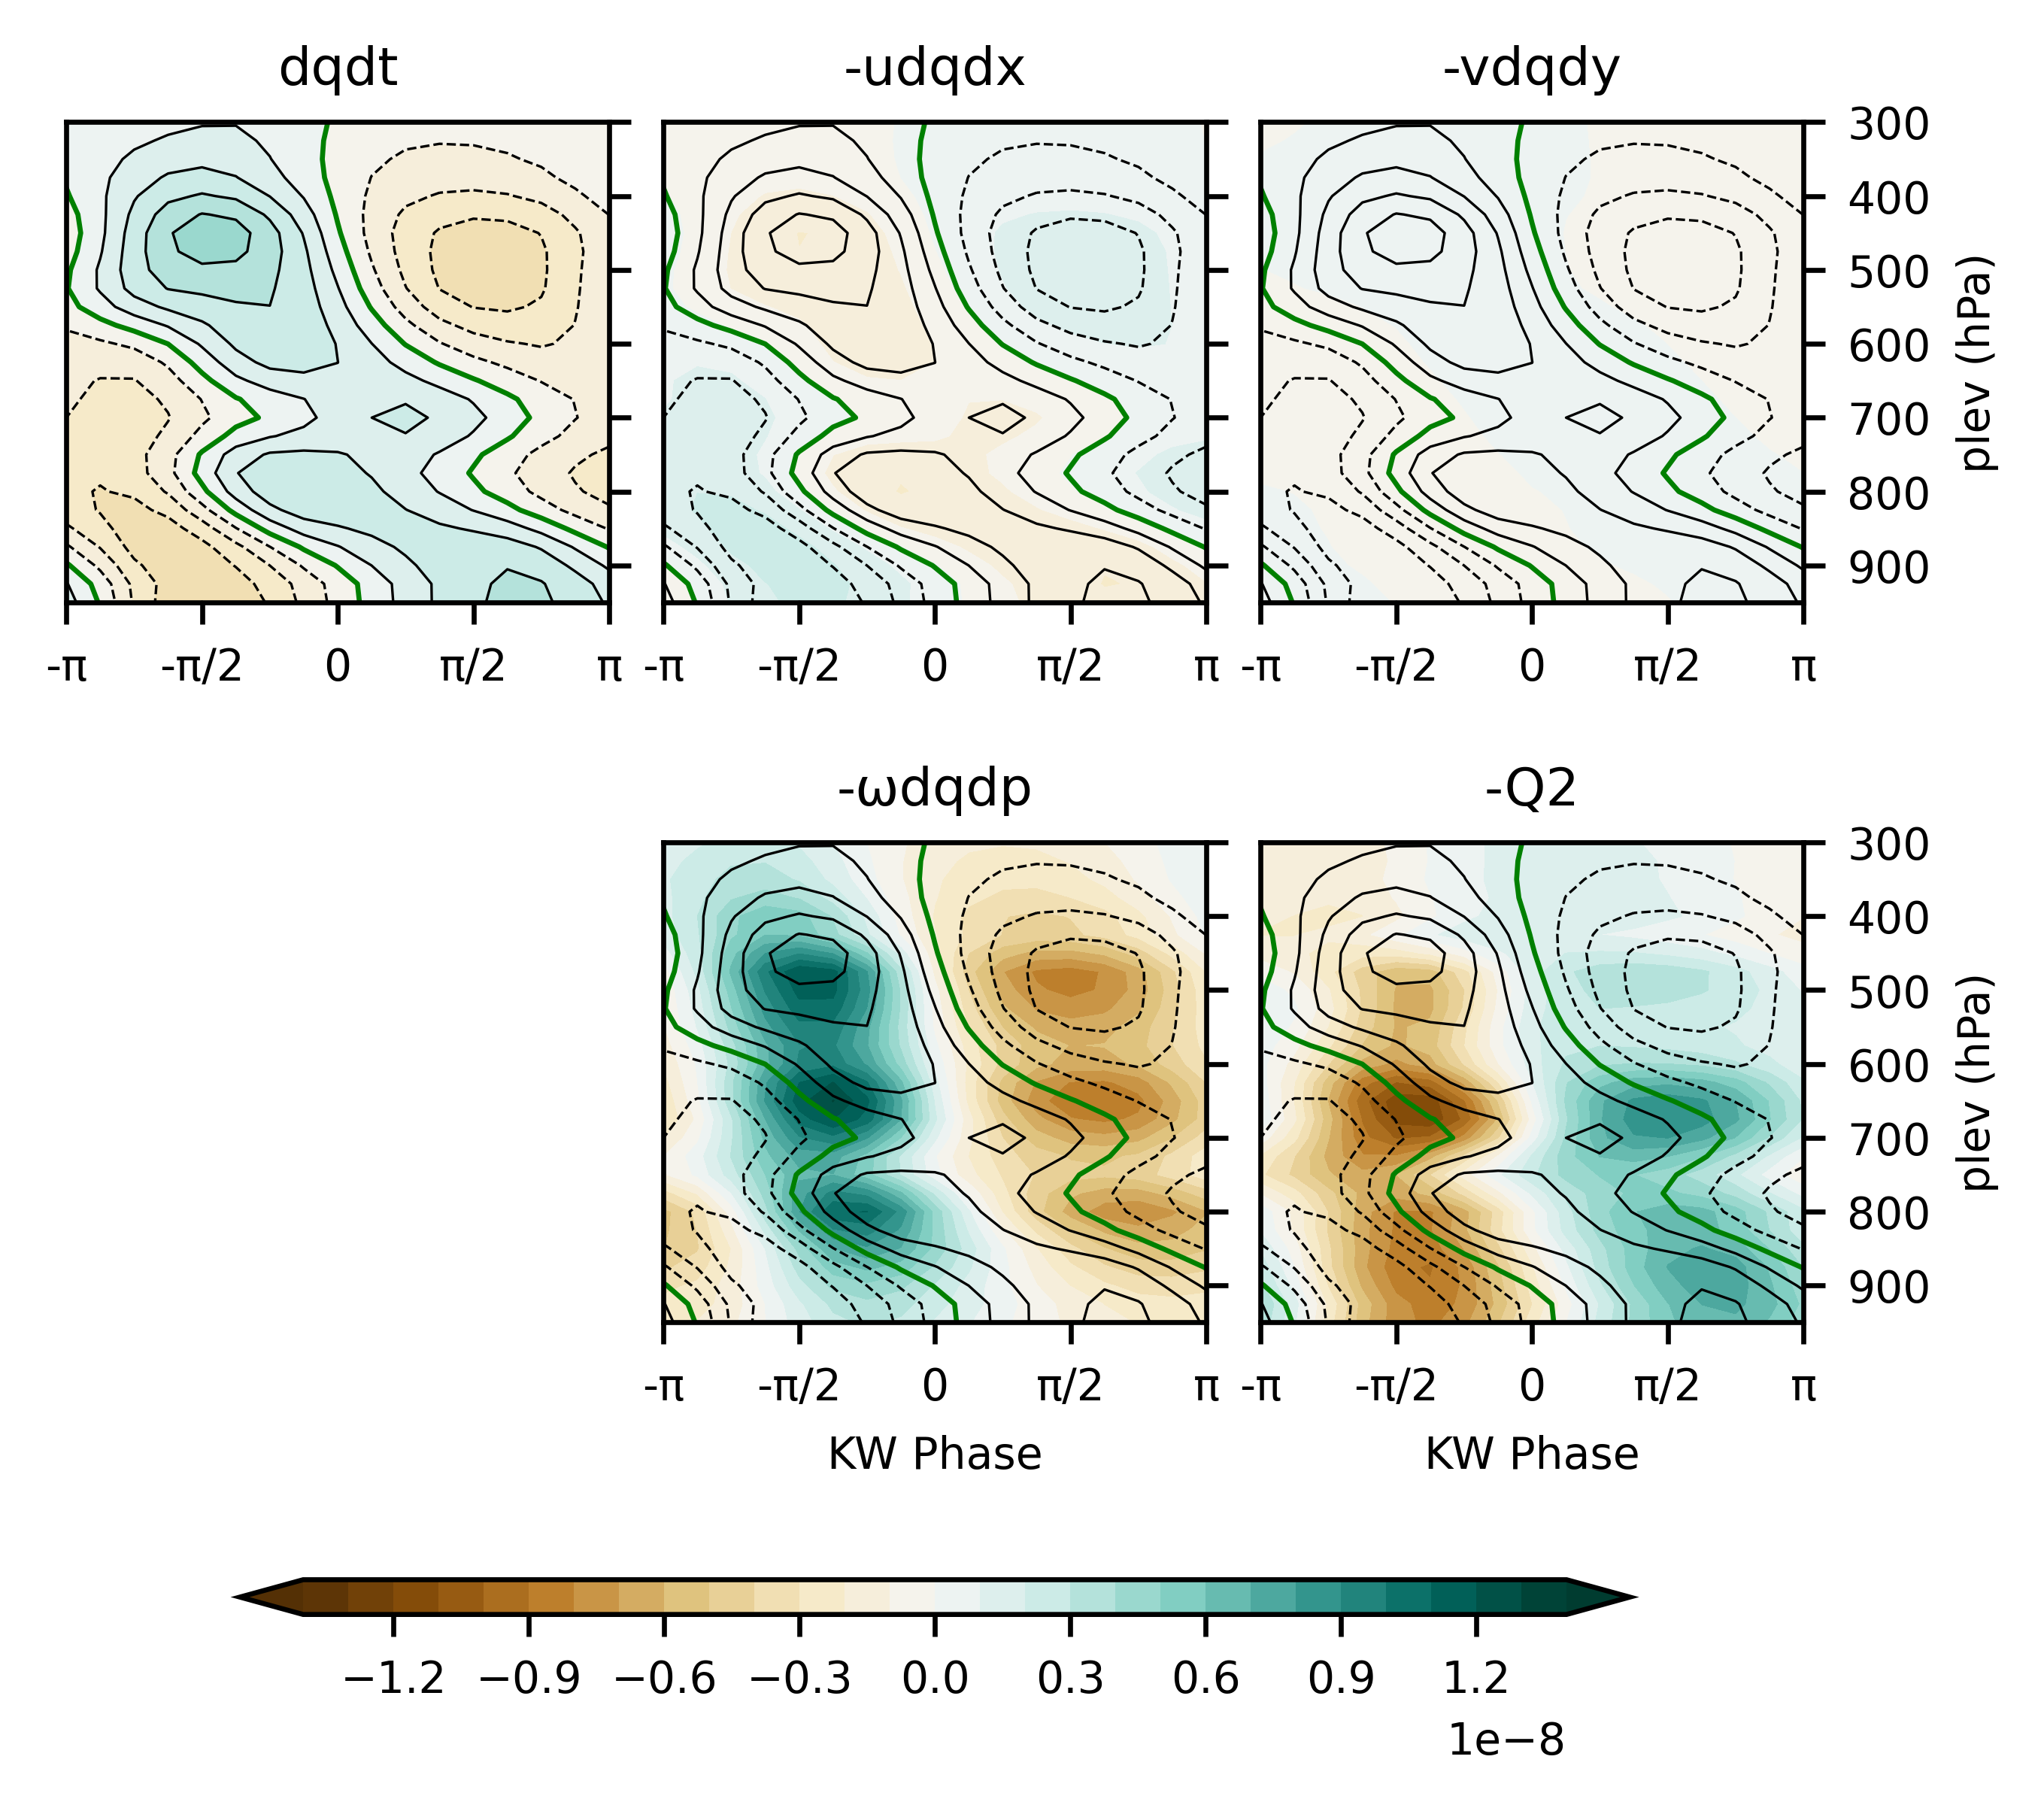

In [62]:
# Plot KW composite vertical structure of each moisture tendency term, start here!
vname_q_budget       = list(['dqdt','udqdx','vdqdy','wdqdp','Q2'])
vname_q_budget_title = list(['dqdt','-udqdx','-vdqdy','-\u03C9dqdp','-Q2'])
iplt_list = np.array([1,2,3,5,6])
font = 7

fig,axes = plt.subplots(2,3,figsize=(5.5, 4),dpi=600)
plt.subplots_adjust(left=0.2,right=0.9,top=0.95,bottom=0,hspace=0.5,wspace=0.1)
plt.rcParams.update({'font.size': font})

# Change color level!
clev = np.arange(-14,15,1)*10**(-9)
clev_p = np.arange(1,15,1)*10**(-9)
clev_n = np.arange(-14,0,1)*10**(-9)
clev_0 = 0

xx, yy = np.meshgrid(phase, plev_KW)

for iplt in range(0,5):
    plt.subplot(2,3,iplt_list[iplt])
    ax = plt.gca()
    VAR_cf = globals() [vname_q_budget[iplt]+'_KW']
    VAR_cn = globals() [vname_q_budget[0]+'_KW'] # q budget total
    if iplt != 0:
        VAR_cf = -VAR_cf
    cf   = plt.contourf(xx, yy, VAR_cf.T, levels=clev, cmap='BrBG', extend='both' )
    cn_p = plt.contour(xx, yy, VAR_cn.T, levels=clev_p, colors='k', linewidths=0.4)
    cn_0 = plt.contour(xx, yy, VAR_cn.T, levels=clev_0, colors='g', linewidths=0.8)
    cn_n = plt.contour(xx, yy, VAR_cn.T, levels=clev_n, colors='k', linestyles='dashed',linewidths=0.4)
    plt.ylim([300, np.max(plev_KW)])
    plt.title(vname_q_budget_title[iplt])
    plt.yticks(np.arange(300,1000,100))
    plt.gca().invert_yaxis()
    plt.xticks(np.arange(-pi,pi+pi/2,pi/2),('-'+PI,'-'+PI+'/2','0',PI+'/2',PI),fontsize=font)
    ax.yaxis.set_label_position("right")
    plt.tick_params(bottom=True,top=False,left=False,right=True)
    if iplt == 2 or iplt == 4:
        plt.tick_params(labelbottom=True,labeltop=False,labelleft=False,labelright=True)
        ax.set_ylabel('plev (hPa)',fontsize=font)
    else:
        plt.tick_params(labelbottom=True,labeltop=False,labelleft=False,labelright=False)       

    if iplt > 2:
        plt.xlabel('KW Phase',fontsize=font)

cb = plt.colorbar(cf,ax=axes,orientation = 'horizontal', shrink=.8, aspect=40,pad=0.15) 

for ax in axes[1:,0]:
    ax.remove()

plt.savefig(figdir+'dqdt_wdqdp_Q2_KW.png',dpi=600)
plt.show()
plt.close()

In [63]:
print(np.min(wdqdp_KW), np.max(wdqdp_KW))

-1.305213541320945e-08 8.985094727466767e-09


[ 1.00000000e+00 -5.24636366e-01  9.23476137e-02  1.19006663e+00
  2.42222118e-01  9.83380044e-14]


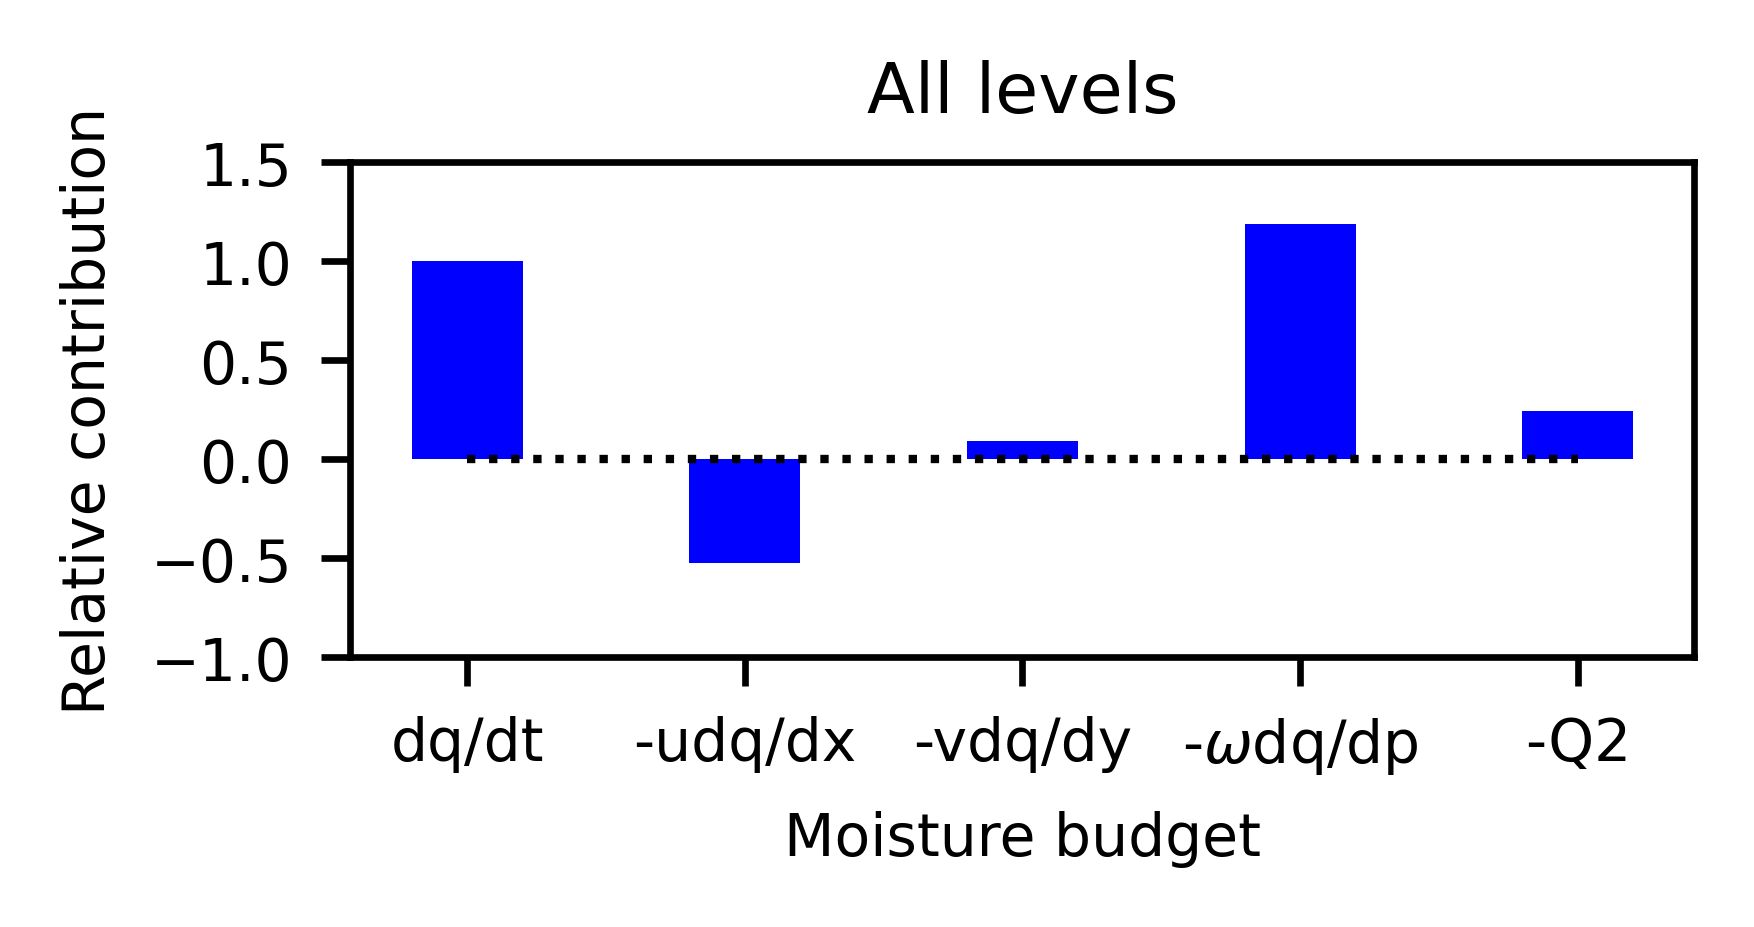

[ 1.00000000e+00 -6.71283987e-01  1.05167373e-02  1.10120989e+00
  5.59557356e-01 -2.48912002e-13]


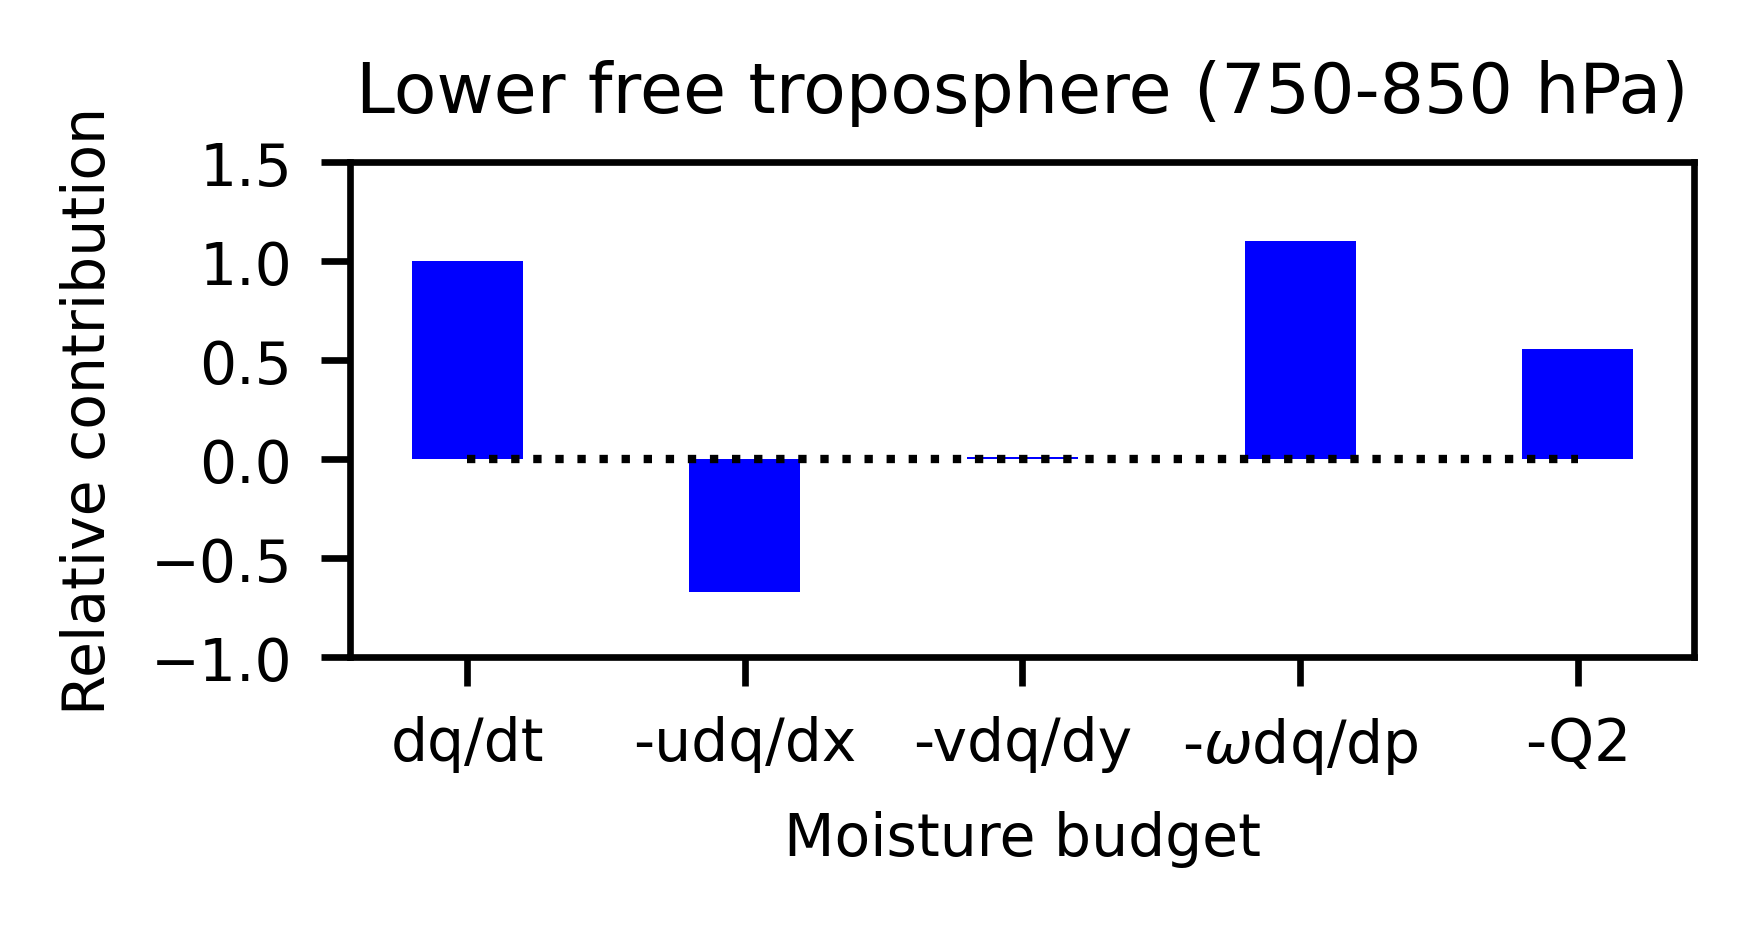

[ 1.00000000e+00 -6.41620568e-01  5.20638305e-02 -4.60088957e-01
  2.04964569e+00 -1.49658064e-13]


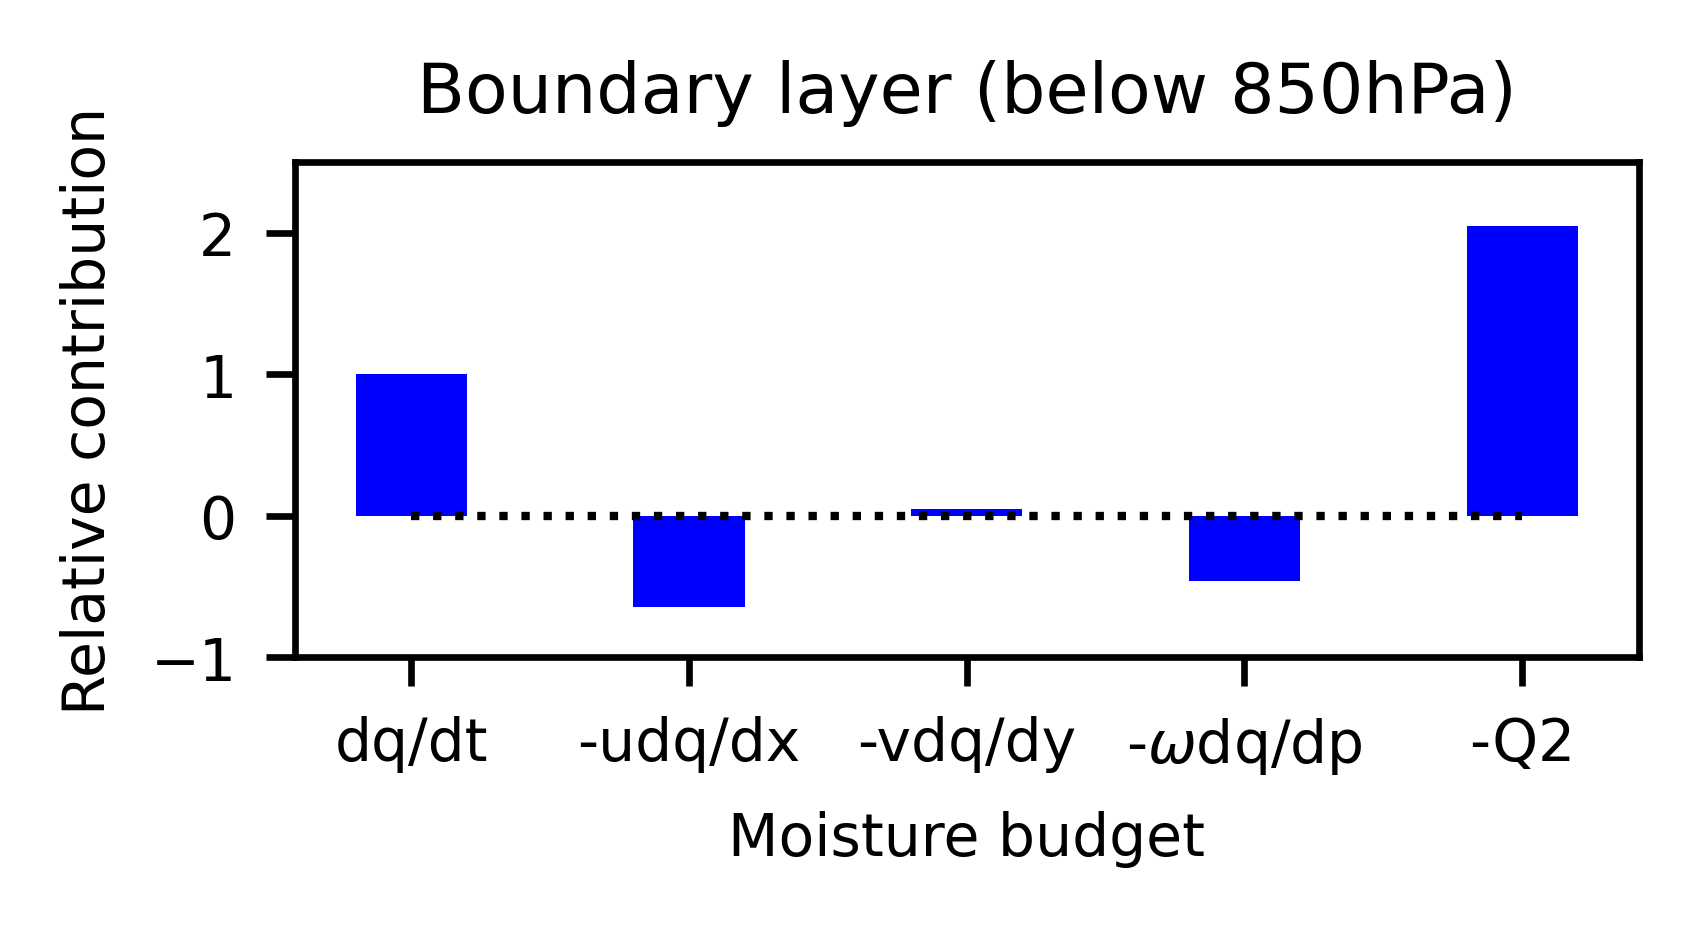

In [64]:
###################
# Calculate contribution of each term to maintenance and propagation
###################################
nlev_KW = np.size(plev_KW)
title_list = list(['All levels','Lower free troposphere (750-850 hPa)','Boundary layer (below 850hPa)'])
figname_list = list(['all_level','750_850','850_1000'])
# contributino to dqdt
for i in range(0,3):
    
    if i==0: # All levels
        ilev_min = 0
        ilev_max = nlev_KW
    elif i==1: # Lower free troposphere (750-850 hPa)
        ilev_min = np.argwhere(plev_KW==750).squeeze()
        ilev_max = np.argwhere(plev_KW==850).squeeze()
    elif i == 2: # Boundary layer (850- hPa)
        ilev_min = np.argwhere(plev_KW==850).squeeze()
        ilev_max = nlev_KW
    
    r_dqdt  = np.sum(dqdt_KW[:,ilev_min:ilev_max+1]*dqdt_KW[:,ilev_min:ilev_max+1])/np.sum(dqdt_KW[:,ilev_min:ilev_max+1]**2)
    r_udqdx = np.sum(dqdt_KW[:,ilev_min:ilev_max+1]*(-udqdx_KW[:,ilev_min:ilev_max+1]))/np.sum(dqdt_KW[:,ilev_min:ilev_max+1]**2)
    r_vdqdy = np.sum(dqdt_KW[:,ilev_min:ilev_max+1]*(-vdqdy_KW[:,ilev_min:ilev_max+1]))/np.sum(dqdt_KW[:,ilev_min:ilev_max+1]**2)
    r_wdqdp = np.sum(dqdt_KW[:,ilev_min:ilev_max+1]*(-wdqdp_KW[:,ilev_min:ilev_max+1]))/np.sum(dqdt_KW[:,ilev_min:ilev_max+1]**2)
    r_Q2    = np.sum(dqdt_KW[:,ilev_min:ilev_max+1]*(-Q2_KW[:,ilev_min:ilev_max+1]))/np.sum(dqdt_KW[:,ilev_min:ilev_max+1]**2)
    r_res   = 1-r_udqdx-r_vdqdy-r_wdqdp-r_Q2
    r = np.array([r_dqdt, r_udqdx, r_vdqdy, r_wdqdp, r_Q2, r_res])
    print(r)
    
    # Plot bar plot of relative contribution of each buget term
    fig,axes = plt.subplots(1,1,figsize=(3.2, 1.5),dpi=600)
    ax = plt.gca()
    plt.subplots_adjust(left=0.2,right=0.9,top=0.8,bottom=0.25)
    plt.rcParams.update({'font.size': font})
    x = np.arange(0,5)
    zero = np.zeros([np.size(x)])
    plt.bar(x, r[:-1], color='blue',width=0.4)
    plt.plot(x, zero, 'k:', linewidth=1)
    plt.xticks(x,('dq/dt','-udq/dx','-vdq/dy','-$\omega$dq/dp','-Q2'))
    plt.xlabel('Moisture budget')
    plt.ylabel('Relative contribution')
    plt.title(title_list[i])
    if i == 0 or i == 1:
        plt.yticks(np.arange(-1,2,0.5))
        plt.ylim([-1,1.5])
    elif i == 2:
        plt.ylim([-1,2.5])
        plt.yticks(np.arange(-1,3,1))
    plt.savefig(figdir+'dqdt_contribution_'+figname_list[i]+'.png',dpi=600)
    plt.show()